# **MODELO RANDOM**



Em um projeto de análise e modelagem de manutenção preditiva, o uso do modelo **Random Forest** junto com a técnica de reamostragem **SMOTE** é importante para lidar com conjuntos de dados desbalanceados, onde o número de falhas (classe minoritária) é muito menor do que o de não-falhas (classe majoritária).

# **Importância das etapas do projeto**

**1. Criação de Features e Colunas de Falhas**

A criação de features (engenharia de atributos) é crucial para transformar dados brutos em variáveis que o modelo possa usar para aprender. No contexto da manutenção preditiva, isso pode incluir a criação de features como:

Falha da Máquina;

Média de temperatura durante o processo;

Desgaste da Ferramento.

A coluna de falhas é a variável-alvo (target) que o modelo tentará prever (0 para não-falha e 1 para falha). Sem ela, a modelagem preditiva não é possível.

**2. Divisão Treino/Teste**

A divisão dos dados em conjuntos de treino e teste é fundamental para avaliar o desempenho do modelo em dados que ele nunca viu. Isso garante que o modelo não esteja apenas "decorando" os dados de treino, mas sim generalizando o conhecimento para novos casos.

**3. Pipeline e SMOTE**

A utilização de um Pipeline é uma boa prática para organizar e automatizar o fluxo de trabalho. No contexto de dados desbalanceados, o SMOTE (Synthetic Minority Over-sampling Technique) é uma técnica de oversampling que cria novas amostras sintéticas da classe minoritária. O SMOTE, ao ser aplicado antes da divisão treino/teste, causaria um vazamento de dados, pois o modelo aprenderia com informações que estariam presentes tanto no conjunto de treino quanto no de teste. A forma correta é aplicar o SMOTE apenas no conjunto de treino, dentro de um pipeline (como o ImbPipeline da biblioteca imblearn), para evitar este problema.

Pipeline antes e depois do SMOTE: o pipeline encapsula as etapas de pré-processamento (como o StandardScaler ou MinMaxScaler) e a aplicação do SMOTE e do modelo (Random Forest). Isso assegura que o pré-processamento e o balanceamento sejam aplicados consistentemente apenas no conjunto de treino, prevenindo o data leakage.

**4. Random Forest para Classificação**

O Random Forest é um modelo de aprendizado de máquina robusto e versátil, composto por múltiplos árvores de decisão. Ele é particularmente eficaz em problemas de classificação por várias razões:

Reduz o sobreajuste (overfitting): ao usar múltiplas árvores e votar na predição final, o modelo se torna mais robusto.

Lida bem com dados não-lineares: não exige que os dados tenham uma relação linear.

Permite a análise de feature_importance: uma característica valiosa do Random Forest é a capacidade de mensurar a importância de cada variável na predição. Isso ajuda a entender quais fatores são mais relevantes para a ocorrência de falhas, auxiliando nas tomadas de decisão de negócio.

**5. Avaliação do Modelo**

A avaliação do modelo é a etapa final e crucial para entender seu desempenho. Em cenários de dados desbalanceados, métricas simples como accuracy podem ser enganosas. Por isso, a análise de outras métricas é essencial:

**Precision:** das vezes que o modelo previu uma falha, quantas delas realmente foram falhas? Alto precision significa pouquíssimos falsos positivos (previsões de falha que não ocorreram).

**Recall:** das falhas que realmente ocorreram, quantas o modelo conseguiu identificar? Alto recall significa poucos falsos negativos (falhas que o modelo não identificou). Em manutenção preditiva, o recall é frequentemente a métrica mais importante, pois perder uma falha real pode ser muito mais custoso do que uma falsa previsão.

**F1-Score:** uma média harmônica entre precision e recall. É uma métrica excelente para conjuntos de dados desbalanceados, pois penaliza modelos que ignoram uma das duas métricas.

**Support:** o número de ocorrências de cada classe na amostra.

**Accuracy:** a proporção de previsões corretas (pode ser enganosa em dados desbalanceados).

**Macro Avg e Weighted Avg:** médias das métricas por classe. O weighted avg é ponderado pelo support de cada classe.

**Matriz de Confusão:** uma tabela que mostra a quantidade de verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos. É uma ferramenta visual e detalhada para entender o desempenho do modelo.

**F1 médio:** a média do F1-score entre as classes. Pode ser útil para uma visão geral.

**Feature_importance:** a análise de quais features o modelo considerou mais importantes para a previsão.

# **BIBLIOTECAS**

In [ ]:
#Importações

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier



In [ ]:
# Configurações para o plot
plt.style.use('ggplot')

In [ ]:
# --- 1. Obtendo e Pré-processando os Dados ---
print("Iniciando o pré-processamento dos dados...")

Iniciando o pré-processamento dos dados...


In [ ]:
df = pd.read_csv('/content/sample_data/bootcamp_train.csv')


# **Criar features combinadas**


*   Potencia da Máquina

*   Torque

*  Velocidade Rotacional

*  Temperatura Ar

*  Temperatura Processo

*  Razão Temperatura

*  Desgaste da Ferramenta

In [ ]:
# Produto entre temperatura do processo e tempo de desgaste da ferramenta
df['temp_x_desgaste'] = df['temperatura_processo'] * df['desgaste_da_ferramenta']

# Razão entre torque e velocidade (indicativo de carga relativa)
df['razao_torque_rotacao'] = df['torque'] / (df['velocidade_rotacional'] + 1e-6)  # evita divisão por zero

# Produto entre temperatura ambiente e velocidade rotacional (condições operacionais)
df['temp_amb_x_rotacao'] = df['temperatura_ar'] * df['velocidade_rotacional']



# **Garantir que as colunas de Falhas sejam Numéricas**

In [ ]:
# Garantir que as colunas de falha sejam numéricas
colunas_falha = ['falha_maquina','FDF (Falha Desgaste Ferramenta)', 'FDC (Falha Dissipacao Calor)',
                 'FP (Falha Potencia)', 'FTE (Falha Tensao Excessiva)', 'FA (Falha Aleatoria)']

# 1. Substituir True/False por 1/0
df[colunas_falha] = df[colunas_falha].replace({'True': 1, 'False': 0})

# 2. Substituir valores inválidos ('N', strings, etc.) por 0
df[colunas_falha] = df[colunas_falha].apply(pd.to_numeric, errors='coerce').fillna(0)

# 3. Converter para inteiro
df[colunas_falha] = df[colunas_falha].astype(int)

print(df[colunas_falha].dtypes)

for coluna in colunas_falha:
    df[coluna] = pd.to_numeric(df[coluna], errors='coerce')
    df[coluna] = df[coluna].fillna(0)

falha_maquina                      int64
FDF (Falha Desgaste Ferramenta)    int64
FDC (Falha Dissipacao Calor)       int64
FP (Falha Potencia)                int64
FTE (Falha Tensao Excessiva)       int64
FA (Falha Aleatoria)               int64
dtype: object


In [ ]:
#Colunas existentes
print(df.columns.tolist())


['id', 'id_produto', 'tipo', 'temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta', 'falha_maquina', 'FDF (Falha Desgaste Ferramenta)', 'FDC (Falha Dissipacao Calor)', 'FP (Falha Potencia)', 'FTE (Falha Tensao Excessiva)', 'FA (Falha Aleatoria)', 'temp_x_desgaste', 'razao_torque_rotacao', 'temp_amb_x_rotacao']


In [ ]:
#Conteúdo de todas colunas
colunas_falha = [col for col in df.columns if 'falha' in col.lower()]
print(colunas_falha)


['falha_maquina', 'FDF (Falha Desgaste Ferramenta)', 'FDC (Falha Dissipacao Calor)', 'FP (Falha Potencia)', 'FTE (Falha Tensao Excessiva)', 'FA (Falha Aleatoria)']


In [ ]:
# Classe Defeito**
if 'classe_defeito' not in df.columns:
    df['classe_defeito'] = df[colunas_falha].idxmax(axis=1)
    df[colunas_falha] = df[colunas_falha].replace({'True': 1, 'False': 0})

In [ ]:
# Garantir tipo inteiro nas falhas
for col in colunas_falha:
    df[col] = df[col].apply(lambda x: 1 if str(x).lower() in ['true', 'sim', '1'] else 0)


In [ ]:
colunas_existentes = [col for col in colunas_falha if col in df.columns]

if colunas_existentes:
    df['classe_defeito'] = df[colunas_existentes].idxmax(axis=1)
else:
    df['classe_defeito'] = None


In [ ]:
# -------------------------
# 1. Verificar contagem de classes
# -------------------------
print("Contagem original de classes:\n", df['classe_defeito'].value_counts())

# -------------------------
# 2. Criar DataFrame balanceado com oversampling
# -------------------------
df_balanced = df.copy()
for classe in df['classe_defeito'].unique():
    subset = df[df['classe_defeito'] == classe]
    if len(subset) == 1:  # se tiver apenas 1 ocorrência
        # duplicar a linha para ter 2 amostras
        df_balanced = pd.concat([df_balanced, subset], ignore_index=True)




Contagem original de classes:
 classe_defeito
falha_maquina           35246
FA (Falha Aleatoria)        1
Name: count, dtype: int64


In [ ]:
# -------------------------
# 3. Atualizar X e y
# -------------------------
X = df_balanced.drop(columns=colunas_falha + ['classe_defeito'], errors='ignore')
y = df_balanced['classe_defeito']

print(X.head())
print(y.head())

   id id_produto tipo  temperatura_ar  temperatura_processo  umidade_relativa  \
0   0     l56434    l           298.3                 309.1              90.0   
1   1     l48741    l           298.2                 308.4              90.0   
2   2     l48850    l           298.2                 307.8              90.0   
3   3     m20947    m           300.9                 310.8              90.0   
4   4     l53849    l           -36.0                 310.5              90.0   

   velocidade_rotacional  torque  desgaste_da_ferramenta  
0                 1616.0    31.1                   195.0  
1                 1388.0    53.8                   137.0  
2                 1528.0    31.1                     NaN  
3                 1599.0    33.0                     7.0  
4                 1571.0    33.9                     NaN  
0    falha_maquina
1    falha_maquina
2    falha_maquina
3    falha_maquina
4    falha_maquina
Name: classe_defeito, dtype: object


In [ ]:
# -------------------------
# 4. Identificação de tipos de coluna
# -------------------------
numericas = X.select_dtypes(include=['number']).columns.tolist()
categoricas = X.select_dtypes(include=['object']).columns.tolist()

print("Features numéricas:", numericas)
print("Features categóricas:", categoricas)

Features numéricas: ['id', 'temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']
Features categóricas: ['id_produto', 'tipo']


In [ ]:
# -------------------------
# 5. Split treino/teste com estratificação
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Confirmação
print("Split concluído com sucesso!")
print("Distribuição y_train:\n", y_train.value_counts())
print("Distribuição y_test:\n", y_test.value_counts())



Split concluído com sucesso!
Distribuição y_train:
 classe_defeito
falha_maquina           28196
FA (Falha Aleatoria)        2
Name: count, dtype: int64
Distribuição y_test:
 classe_defeito
falha_maquina    7050
Name: count, dtype: int64


In [ ]:
# === Pré-processamento ===
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessador = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

# === Pipeline com SMOTE e RandomForest ===
smote = SMOTE(random_state=42)

modelo_final = ImbPipeline(steps=[
    ('preprocessador', preprocessador),
    ('smote', smote),
    ('classificador', RandomForestClassifier(
        n_estimators=100,
        criterion='gini',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=2,
        random_state=42
    ))
])

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



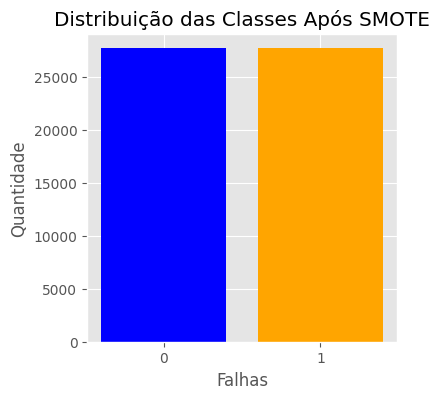

Distribuição após SMOTE:
 falha_maquina
0    27678
1    27678
Name: count, dtype: int64


In [ ]:
# === Obter distribuição após SMOTE ===
# Precisamos aplicar preprocessamento antes do SMOTE manualmente
X_train_transformed = preprocessador.fit_transform(X_train)
X_resampled, y_resampled = smote.fit_resample(X_train_transformed, y_train)

contagem_smote = y_resampled.value_counts()
plt.figure(figsize=(4,4))
plt.bar(contagem_smote.index.astype(str), contagem_smote.values, color=['blue','orange'])
plt.title('Distribuição das Classes Após SMOTE')
plt.xlabel('Falhas')
plt.ylabel('Quantidade')
plt.show()
print("Distribuição após SMOTE:\n", contagem_smote)



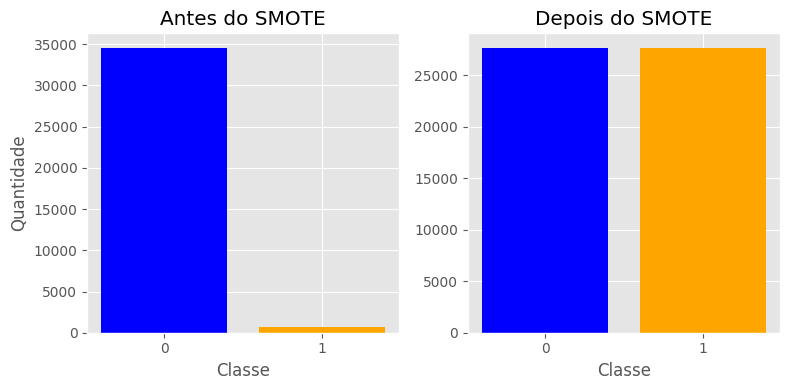


Relatório de Classificação:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6920
           1       0.94      0.84      0.89       130

    accuracy                           1.00      7050
   macro avg       0.97      0.92      0.94      7050
weighted avg       1.00      1.00      1.00      7050



In [ ]:
# Comparação lado a lado
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].bar(contagem_original.index.astype(str), contagem_original.values, color=['blue','orange'])
ax[0].set_title('Antes do SMOTE')
ax[0].set_xlabel('Classe')
ax[0].set_ylabel('Quantidade')

ax[1].bar(contagem_smote.index.astype(str), contagem_smote.values, color=['blue','orange'])
ax[1].set_title('Depois do SMOTE')
ax[1].set_xlabel('Classe')

plt.tight_layout()
plt.show()

# ===Treinar modelo ===
modelo_final.fit(X_train, y_train)

# === Avaliação ===
y_pred = modelo_final.predict(X_test)
print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred))


F1 Score médio (CV): 0.8916

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6920
           1       0.94      0.84      0.89       130

    accuracy                           1.00      7050
   macro avg       0.97      0.92      0.94      7050
weighted avg       1.00      1.00      1.00      7050



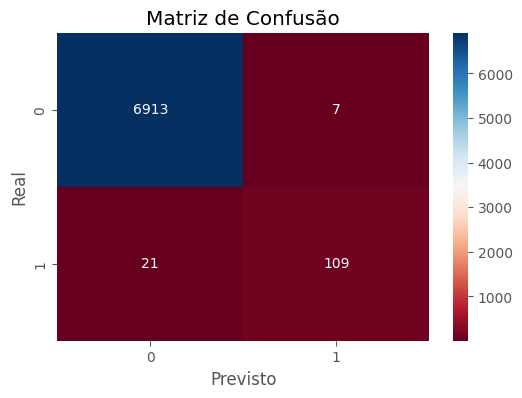

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Validação cruzada para avaliar robustez
scores = cross_val_score(modelo_final, X_train, y_train, cv=5, scoring='f1')
print(f'F1 Score médio (CV): {scores.mean():.4f}')


# Treinar modelo
modelo_final.fit(X_train, y_train)


# Predições
y_pred = modelo_final.predict(X_test)


# Relatório de métricas
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))


# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdBu')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(modelo_final, X, y, cv=5, scoring='f1_weighted')
print(f"F1 médio: {scores.mean():.4f} ± {scores.std():.4f}")

F1 médio: 0.9966 ± 0.0019


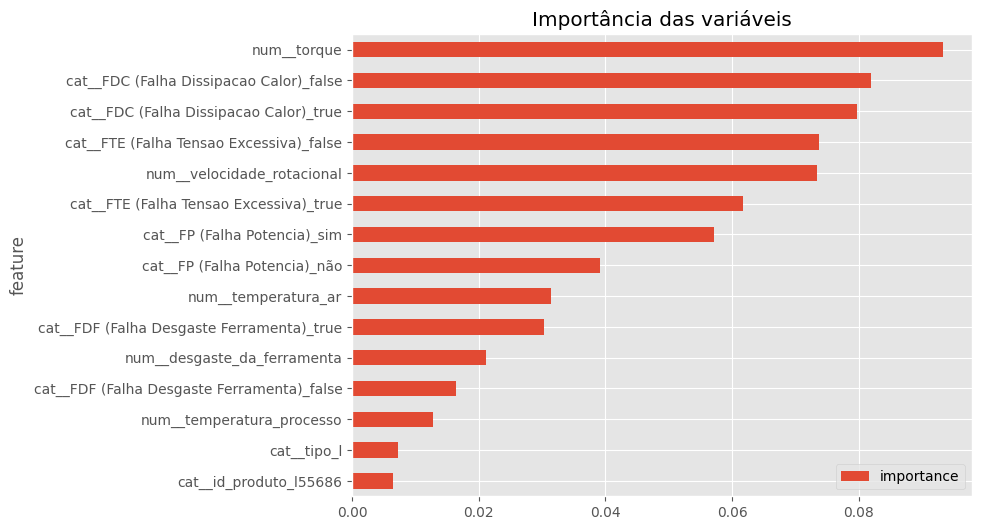

In [37]:
# Após o fit
modelo_rf = modelo_final.named_steps['classificador']
importancias = modelo_rf.feature_importances_
nomes = preprocessador.get_feature_names_out()
importancias_df = pd.DataFrame({'feature': nomes, 'importance': importancias}).sort_values(by='importance', ascending=False)

# Features de Importância
importancias_df.head(15).plot(kind='barh', x='feature', y='importance', figsize=(8, 6), title='Importância das variáveis')
plt.gca().invert_yaxis()
plt.show()